In [201]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import skimage
from scipy import ndimage

# Edge Detection

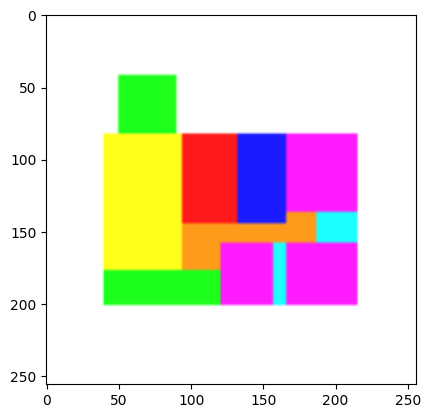

In [228]:
img = cv2.imread('img.png')[...,::-1]
plt.imshow(img)

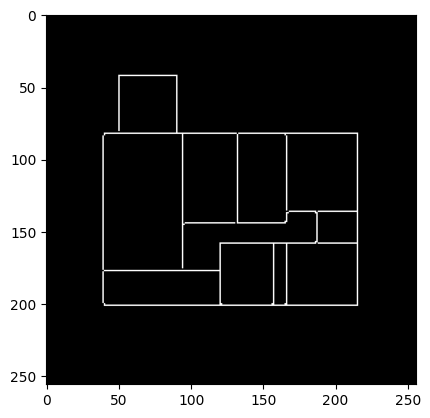

In [229]:
edges = cv2.Canny(img, 50, 100)
plt.imshow(edges, cmap='gray')

In [230]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

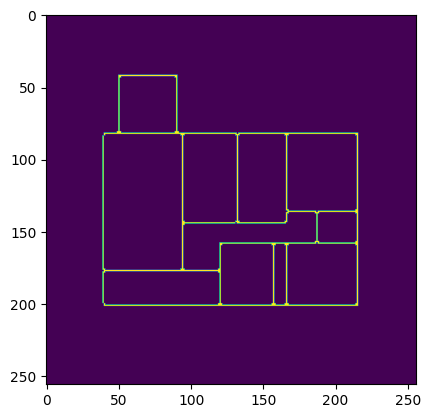

In [231]:
plt.imshow(edges)

# Find Contours

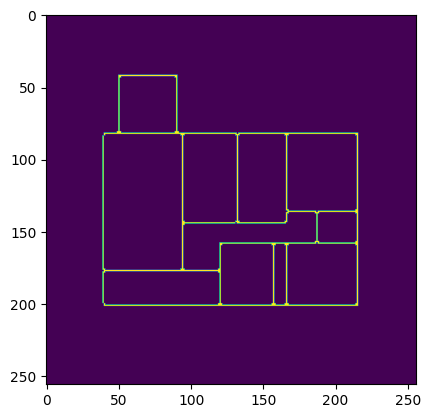

In [232]:
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
plt.imshow(edges)

In [337]:
# https://stackoverflow.com/questions/71928845/get-the-location-of-all-contours-present-in-image-using-opencv-but-skipping-tex
result = img.copy()
sum_contours = np.zeros_like(img, dtype=np.uint8)
i = 1
for c in contours:
    contour_img = np.zeros_like(img, dtype=np.uint8)
    cv2.drawContours(contour_img, c, -1, (0,0,255), 1)
    cv2.imwrite("contour/contour_{0}.jpg".format(i),contour_img)
    sum_contours += contour_img
    i = i + 1

# Find Contour Overlap

In [297]:
#https://stackoverflow.com/questions/55641425/check-if-two-contours-intersect
def contourIntersect(original_image, contour1, contour2):
    # Two separate contours trying to check intersection on
    contours = [contour1, contour2]

    # Create image filled with zeros the same size of original image
    blank = np.zeros(original_image.shape[0:2])

    # Copy each contour into its own image and fill it with '1'
    image1 = cv2.drawContours(np.zeros_like(original_image, dtype=np.uint8), contours[0], -1, (0,0,255), 1)
    image2 = cv2.drawContours(np.zeros_like(original_image, dtype=np.uint8), contours[1], -1, (0,0,255), 1)
    
    # Use the logical AND operation on the two images
    # Since the two images had bitwise and applied to it,
    # there should be a '1' or 'True' where there was intersection
    # and a '0' or 'False' where it didnt intersect
    intersection = np.logical_and(image1, image2)
    
    # Check if there was a '1' in the intersection
    # modified not all
    return image1, image2, intersection.any()

True


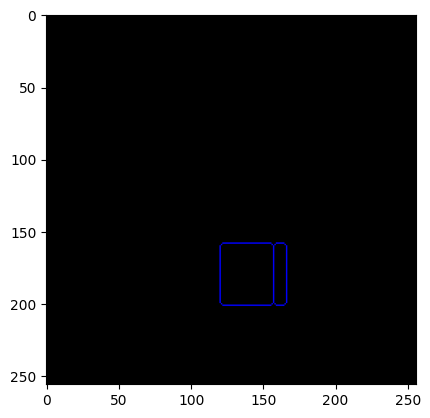

In [298]:
img1, img2, b = contourIntersect(img, contours[1], contours[2])
plt.imshow(img1 + img2,cmap='gray')
print(b)

False


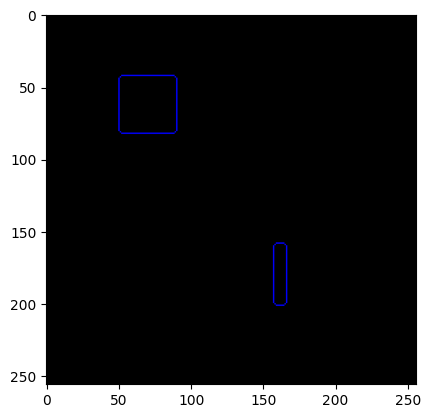

In [299]:
img1, img2, b = contourIntersect(img, contours[1], contours[10])
plt.imshow(img1 + img2,cmap='gray')
print(b)

In [288]:
# discard the first one since it is the outer most edge
contours = contours[1:]

In [303]:
connectivity = []
for i in range(len(contours)):
    connectivity.append([])
    for j in range(len(contours)):
        if j != i:
            img1, img2, boo = contourIntersect(img, contours[i], contours[j])
            if boo:
                connectivity[i].append(j)

In [304]:
# format: index is contour, array at index is connected contours
print(connectivity)

[[2, 5, 9], [2, 3, 5], [0, 1, 5], [1, 4, 5], [3, 5, 6], [0, 1, 2, 3, 4, 6, 7, 8, 9], [4, 5, 7], [5, 6, 8], [5, 7, 9], [0, 5, 8, 10], [9]]


In [358]:
def find_centroid(contour):
    x, y = contour.mean(axis=0)[0].astype(int)
    return y, x

def find_centroids(contours):
    centroids = []
    for c in contours:
        y, x = find_centroid(c)
        centroids.append([x, y])
        
    return centroids

# Draw Centroids & Lines

In [419]:
def draw_lines(centroids, connectivity, cur_img):
    for i in range(len(centroids)):
        for connected in connectivity[i]:
            cv2.line(cur_img, centroids[i], centroids[connected], (255,255,255), 1)

In [424]:
def draw_centroids(contours, og_img, cur_img):
    for c in contours:
        y, x = find_centroid(c)
        color = og_img[y, x, :]
        color = (int(color[0]), int(color[1]), int(color[2])) 
        cv2.circle(cur_img,(x, y), 3, tuple(color), -1)
        print(np.array(color)/255)

[0.10588235 1.         0.10588235]
[0.10588235 1.         1.        ]
[1.         0.10588235 1.        ]
[1.         0.10588235 1.        ]
[0.10588235 1.         1.        ]
[1.         0.60784314 0.10588235]
[1.         0.10588235 1.        ]
[0.10588235 0.10588235 1.        ]
[1.         0.10588235 0.10588235]
[1.         1.         0.10588235]
[0.10588235 1.         0.10588235]


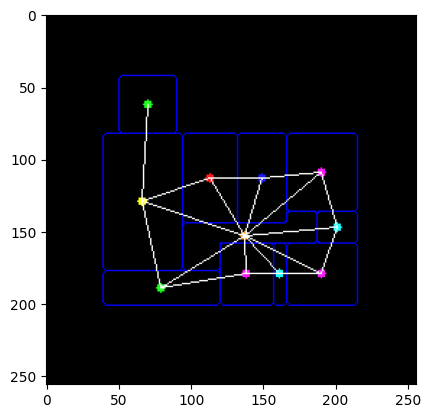

In [425]:
new_img = sum_contours.copy()
draw_centroids(contours, img, new_img)
centroids = find_centroids(contours)
draw_lines(centroids, connectivity, new_img)
plt.imshow(new_img)

# A Proper Graph...

In [426]:
import networkx as nx

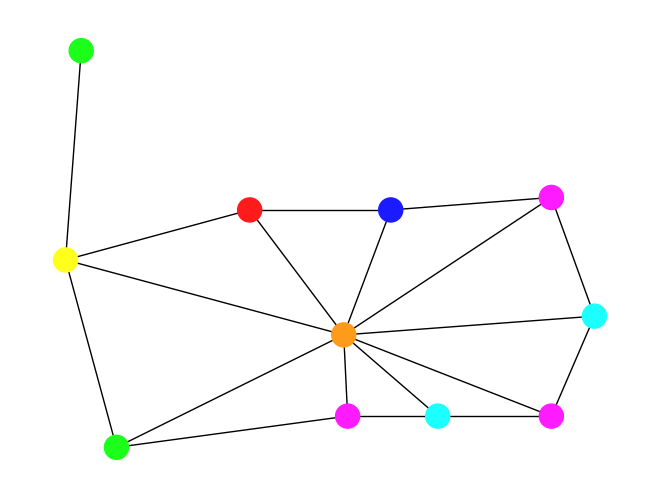

In [496]:
G = nx.Graph()
colors = []
for i in range(len(centroids)):
    y, x = centroids[i]
    color = img[x, y, :] / 255.
    colors.append(color)
    G.add_node(i)
    for j in range(len(connectivity[i])):
        G.add_edge(i, connectivity[i][j])

# hased nodes are unsorted, copy into new graph to sort
H = nx.Graph()
H.add_nodes_from(sorted(G.nodes(data=True)))
H.add_edges_from(G.edges(data=True))

# color map is order dependent
nx.draw(H, centroids, node_color=colors)
plt.gca().invert_yaxis()
plt.show()

(-0.5, 255.5, 255.5, -0.5)

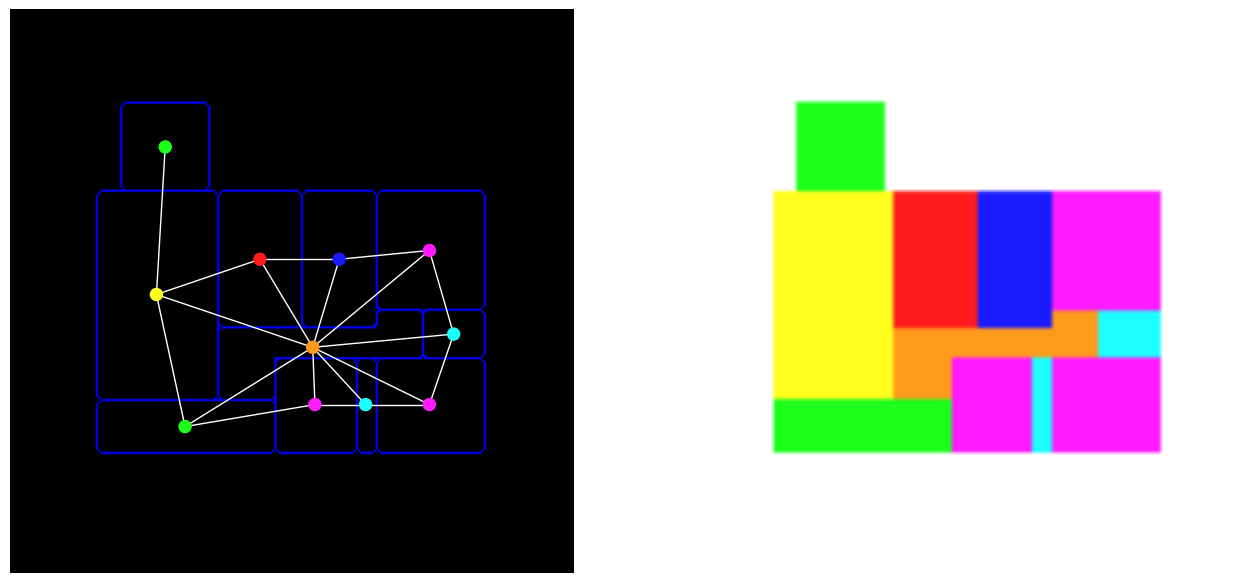

In [498]:
plt.figure(figsize = (16,8))
plt.subplot(1, 2, 1)
nx.draw(H, centroids, node_color=colors, edge_color=np.zeros_like(colors)+1, node_size=75)
plt.gca().invert_yaxis()
plt.imshow(sum_contours)
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.axis('off')

In [499]:
nx.to_dict_of_dicts(G)

{0: {2: {}, 5: {}, 9: {}},
 2: {0: {}, 1: {}, 5: {}},
 5: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 6: {}, 7: {}, 8: {}, 9: {}},
 9: {0: {}, 5: {}, 8: {}, 10: {}},
 1: {2: {}, 3: {}, 5: {}},
 3: {1: {}, 4: {}, 5: {}},
 4: {3: {}, 5: {}, 6: {}},
 6: {4: {}, 5: {}, 7: {}},
 7: {5: {}, 6: {}, 8: {}},
 8: {5: {}, 7: {}, 9: {}},
 10: {9: {}}}